# Uncertainty quantification of H2G-Net

In this tutorial, we will demonstrate how to perform uncertainty quantification of our pretrained H2G-Net model.

For now, we only care about the final refinement network and we will use a Monte Carlo dropout approach.

In [ ]:
!pip install --trusted-host pypi.python.org pytest-xdist
!pip install --trusted-host pypi.python.org --upgrade pip

In [ ]:
!python -V

In [ ]:
!pip install -q numpy==1.23.3 matplotlib tensorflow==1.13.1 pyfast

In [ ]:
!wget https://github.com/AICAN-Research/H2G-Net/releases/download/pretrained-models/patchwise_mobilenet_network_breast_cancer.onnx
!wget https://github.com/AICAN-Research/H2G-Net/releases/download/pretrained-models/refinement_network_breast_cancer.h5

In [ ]:
import fast

# download model
fast.DataHub().download('breast-tumour-segmentation-model')

In [ ]:
import fast
import numpy as np

# use pyFAST to generate the heatmap
wsi_path = "/Users/andreped/Downloads/breast_wsis/B.tif"

reader = fast.WholeSlideImageImporter.create(filename=wsi_path)
tissue = fast.TissueSegmentation.create().connect(reader)
patch = fast.PatchGenerator.create(width=256, height=256, level=2)\
    .connect(0, reader)\
    .connect(1, tissue)
network = fast.NeuralNetwork.create(modelFilename="./patchwise_mobilenet_network_breast_cancer.onnx", scaleFactor=0.003921568627451)\
    .connect(patch)
stitcher = fast.PatchStitcher.create().connect(network)
finish = fast.RunUntilFinished.create().connect(stitcher)

finish.run()

heatmap = np.asarray(finish.getOutputData())

print(heatmap.shape)

In [2]:
from tensorflow.python.keras.models import load_model

model = load_model("refinement_network_breast_cancer.h5", compile=False)

In [33]:
import h5py
import numpy as np

with h5py.File("temporary-image-file-2.h5", "r") as f:
    thumbnail = np.asarray(f["thumbnail"])
    image = np.asarray(f["image"])
    heatmap = np.asarray(f["heatmap"])

print(heatmap.shape)

(1, 1024, 1024, 1)


In [34]:
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras.backend as K
import cv2


def predict_with_dropout(model, x):
    func = K.function([model.input, K.learning_phase()], [model.output])
    return np.array(func([x, 1])[0])


sess = tf.Session()

nb_mc_runs = 10
avg_out = np.zeros_like(heatmap[..., 0])
std_out = np.zeros_like(heatmap[..., 0])
for i in range(nb_mc_runs):
    input_ = np.concatenate([image, heatmap], axis=-1)
    input_ = tf.convert_to_tensor(input_)

    output_tensor = predict_with_dropout(model, [image, heatmap])

    pred = output_tensor[..., 1]

    avg_out += pred / nb_mc_runs
    std_out += (pred ** 2) / nb_mc_runs

std_out = np.sqrt(np.abs(std_out - avg_out ** 2))

del output_tensor, input_, avg_out


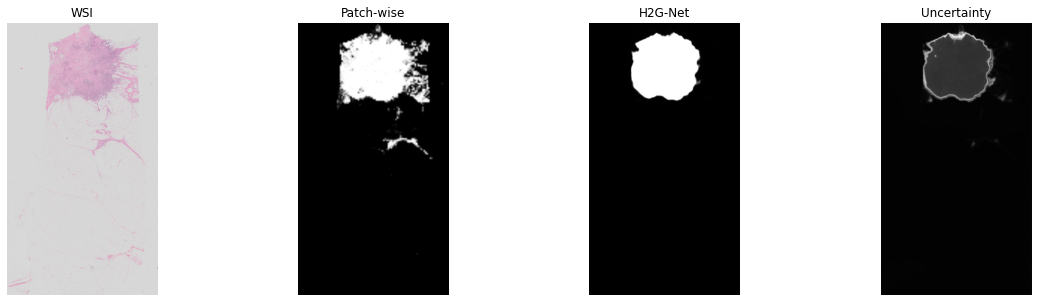

In [ ]:
new_shape = thumbnail.shape[:2][::-1]
new_shape = int(new_shape[0] / 4), int(new_shape[1] / 4)

thumbnail = cv2.resize(thumbnail, new_shape)
heatmap = cv2.resize(heatmap.squeeze(axis=0), new_shape)
pred = cv2.resize(pred.squeeze(axis=0), new_shape)
std_out = cv2.resize(std_out.squeeze(axis=0), new_shape)


fig, ax = plt.subplots(1, 4, figsize=(20, 10))
ax[0].imshow(thumbnail)
ax[1].imshow(heatmap, cmap="gray", vmin=0, vmax=1)
ax[2].imshow(pred, cmap="gray", vmin=0, vmax=1)
# ax[3].imshow(avg_out.squeeze(axis=0), cmap="gray", vmin=0, vmax=1)
ax[3].imshow(std_out, cmap="gray", vmin=0)

names = ["WSI", "Patch-wise", "H2G-Net", "Uncertainty"]

for i, name in enumerate(names):
    ax[i].set_title(name)
    ax[i].axis("off")
# ax[4].imshow(std_out.squeeze(axis=0), cmap="gray", vmin=0)

plt.show()
